In [1]:
import pandas as pd
import numpy as np
import psycopg2 as pg
import matplotlib.pyplot as plt

# Null values over time analysis

In [15]:
dates = pd.DataFrame(columns=['date'],data=pd.date_range("2020-03-10","2022-03-10"))

daily_null_count = pd.read_sql_query('''
select * from
(
select * from
(
select "SG_UF_NOT" as uf,"DT_INTERNA" as date,count(*) as non_null from srag_bruto sb 
where "CARDIOPATI" is not null
group by "SG_UF_NOT","DT_INTERNA"
) as t1
natural join
(
select "SG_UF_NOT" as uf, "DT_INTERNA" as date,count(*) as total from srag_bruto sb
group by "SG_UF_NOT","DT_INTERNA"
) as t2
) as t12
''', conn)

daily_null_count = daily_null_count[daily_null_count["date"].str[-4:].isin(["2020","2021","2022"])]
daily_null_count['date'] = pd.to_datetime(daily_null_count['date'])
daily_null_count.set_index('date', inplace = True)
df_dict_uf = {uf: daily_null_count[daily_null_count.uf == uf].join(other=dates.set_index('date'), how="right").fillna(0)
             for uf in uf_list}

for uf in uf_list:
    df_dict_uf[uf]['ratio'] = df_dict_uf[uf]['non_null']/df_dict_uf[uf]['total']
    df_dict_uf[uf].fillna(0,inplace=True)
    df_dict_uf[uf].sort_values('date',inplace=True)
    df_dict_uf[uf] = df_dict_uf[uf][df_dict_uf[uf].index > pd.to_datetime("2020-03-04")]

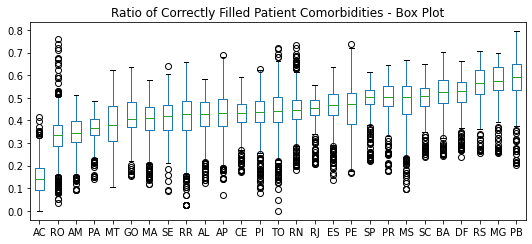

In [17]:
index = df_dict_uf["SP"].index
df = pd.DataFrame(index = index, data = {uf: df_dict_uf[uf]["ratio"].rolling(14).mean()
        for uf in uf_list})
df = pd.DataFrame(index = index, data = df).tail(727-21).interpolate().fillna(method = "bfill")
df = df[df.median().sort_values().index]


plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True



ax = df.plot(kind='box', title='Ratio of Correctly Filled Patient Comorbidities - Box Plot')


plt.show()

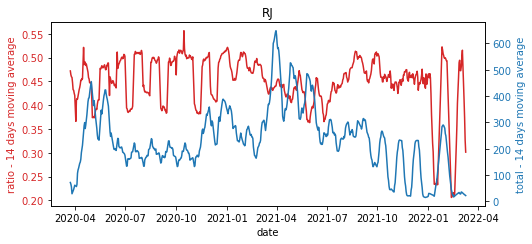

In [18]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('date')
ax1.set_ylabel('ratio - 14 days moving average', color=color)
ax1.plot(df_dict_uf["RJ"]['ratio'].rolling(14).mean(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('total - 14 days moving average', color=color)  # we already handled the x-label with ax1
ax2.plot(df_dict_uf["RJ"]['total'].rolling(14).mean(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("RJ")

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Selecting Dates

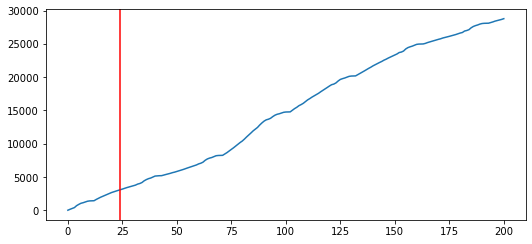

In [55]:
hospitalizations = pd.Series(range(1,201))
T = True
for d in range(1,201):
    iteration = df_dict_uf["RJ"]
    hospitalizations[d] = iteration[iteration.index >= pd.to_datetime("2021-01-01")]["non_null"].head(d).sum()
    if hospitalizations[d] >= 3000 and T:
        T = False
        d3000 = d

plt.plot(hospitalizations)
plt.axvline(x = d3000, color = 'red')
plt.show()

In [56]:
d3000

24

# Importing Dataset

In [58]:
dataset = pd.read_sql_query('''
select * from srag_bruto sb 
where "SG_UF_NOT" = 'RJ' and 
"CARDIOPATI" is not null
''', conn)
dataset = dataset[dataset['DT_INTERNA'].str[-4:].isin(["2020","2021","2022"])]
dataset['DT_INTERNA'] = pd.to_datetime(dataset['DT_INTERNA'])
dataset = dataset[(dataset['DT_INTERNA'] <= pd.to_datetime("2021-01-01") + pd.Timedelta(d3000,unit="D")) &
                 (dataset['DT_INTERNA'] >= pd.to_datetime("2021-01-01"))]
dataset.reset_index(drop = True, inplace = True)
dataset

,DT_NOTIFIC,SEM_NOT,DT_SIN_PRI,SEM_PRI,SG_UF_NOT,ID_REGIONA,CO_REGIONA,ID_MUNICIP,CO_MUN_NOT,ID_UNIDADE,...,DOSE_2_COV,DOSE_REF,FAB_COV_1,FAB_COV_2,FAB_COVREF,LOTE_REF,LAB_PR_COV,LOTE_1_COV,LOTE_2_COV,FNT_IN_COV
0,28/01/2021,4,14/01/2021,2,RJ,None,None,CAMPOS DOS GOYTACAZES,330100,HOSPITAL GERAL DE GUARUS,...,None,None,None,None,None,None,None,None,None,1.0
1,19/01/2021,3,15/01/2021,2,RJ,None,None,NITEROI,330330,HOSPITAL UNIVERSITARIO ANTONIO PEDRO,...,None,None,None,None,None,None,None,None,None,NaN
2,01/05/2021,17,01/05/2021,17,RJ,None,None,RIO DE JANEIRO,330455,CASA DE PORTUGAL,...,None,None,None,None,None,None,None,None,None,1.0
3,07/04/2021,14,31/03/2021,13,RJ,None,None,RIO DE JANEIRO,330455,HOSPITAL ADVENTISTA SILVESTRE,...,None,None,None,None,None,None,None,None,None,1.0
4,06/05/2021,18,13/01/2021,2,RJ,None,None,NITEROI,330330,IUN,...,None,None,None,None,None,None,None,None,None,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3171,25/01/2021,4,25/01/2021,4,RJ,None,None,CABO FRIO,330070,UNIDADE DE PRONTO ATENDIMENTO UPA II,...,None,None,None,None,None,None,None,None,None,NaN
3172,14/01/2021,2,04/01/2021,1,RJ,None,None,RIO DE JANEIRO,330455,HOSPITAL VITORIA AMC,...,None,None,None,None,None,None,None,None,None,NaN
3173,10/01/2021,2,10/01/2021,2,RJ,None,None,RIO DE JANEIRO,330455,HOSPITAL SAO LUCAS,...,None,None,None,None,None,None,None,None,None,NaN
3174,21/01/2021,3,14/01/2021,2,RJ,None,None,CAMPOS DOS GOYTACAZES,330100,HOSPITAL FERREIRA MACHADO,...,None,None,None,None,None,None,None,None,None,1.0


In [59]:
cols = ['CARDIOPATI','HEMATOLOGI','SIND_DOWN',
        'HEPATICA','ASMA','DIABETES',
        'NEUROLOGIC','PNEUMOPATI','IMUNODEPRE',
        'RENAL','OBESIDADE']
for col in cols:
    dataset[col] = dataset[col].fillna(2).apply(lambda x: 1 if x == 1.0 else 0)

# Exporting Dataset

In [60]:
dataset.to_csv("data.csv")